# Influence Simulation for Poisson Random Graph

We consider the following undirected graphs for simulating influence networks and cascades.

     erdos_renyi_graph - Poisson/Binomial Degree Distribution

In [1]:
from SimulationHelper import *
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
## Multiprocessing Package - Speed up simulation
from multiprocessing import cpu_count
from dask.distributed import Client, progress
import dask
client = Client(threads_per_worker=2)
client

/home/michael/miniconda3/envs/dask/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:39111 Dashboard: http://127.0.0.1:39483/status,Cluster Workers: 8 Cores: 16 Memory: 33.60 GB


## Simulation of Influentials in a Poisson Random Graph

The following code is for simulating and measuring the cascade of influentials.

In [7]:
######################################################################
############################# Parameters #############################
######################################################################

N = 1000
q = 0.1   
phi = 0.18
max_n_avg = 8
increment = 0.2
num_simulations = 100


n_avg = np.arange(1, max_n_avg, increment)
p = [avg/(N-1) for avg in n_avg]
n = len(p)

In [8]:
%%time
pool = []
x = []
for i in tqdm(range(num_simulations)):
    for j in range(n):
        pool.append(dask.delayed(run_simulation_RG)(N, p[j], phi, q))

results = dask.compute(pool)

100%|██████████| 100/100 [00:00<00:00, 443.74it/s]


CPU times: user 15min 57s, sys: 1min 5s, total: 17min 2s
Wall time: 2h 12min 52s


### Post Processing

This code reformats the simulation output for plotting.

In [9]:
tmp = np.array(results[0])
dims = (num_simulations, n)
names = ["Influential", "Normal"]

S_influential = np.reshape(tmp[:,0], dims)
t_influential = np.reshape(tmp[:,2], dims)
S_normal = np.reshape(tmp[:,1], dims)
t_normal = np.reshape(tmp[:,3], dims)

# Averaged Time of Influenced Nodes
T_influential = np.apply_along_axis(np.mean, 0, t_influential)
T_normal = np.apply_along_axis(np.mean, 0, t_normal)

# Number of Nodes of Network Influenced
N_influential = np.apply_along_axis(np.mean, 0, S_influential)
N_normal = np.apply_along_axis(np.mean, 0, S_normal)

# Proportion of Network Influenced
P_influential = [x/N for x in N_influential]
P_normal = [x/N for x in N_normal]

### Plotting

The below plots represent 

- Comparison of (average) number of nodes influenced by influential/normal nodes as average degree changes
- Comparison of (average) percentage of nodes influenced by influential/normal nodes as average degree changes
- Comparison of (average) time of node influence by influential/normal nodes as average degree changes


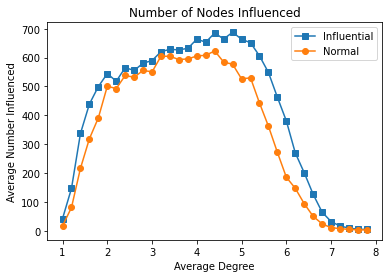

In [10]:
plt.plot(n_avg, N_influential, "-s")
plt.plot(n_avg, N_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Number of Nodes Influenced")
plt.legend(names)

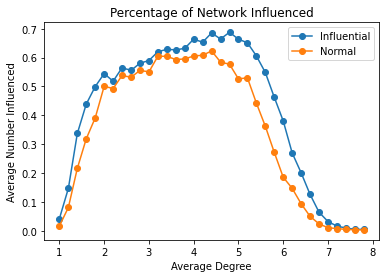

In [11]:
plt.plot(n_avg, P_influential, "-o")
plt.plot(n_avg, P_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Percentage of Network Influenced")
plt.legend(names)

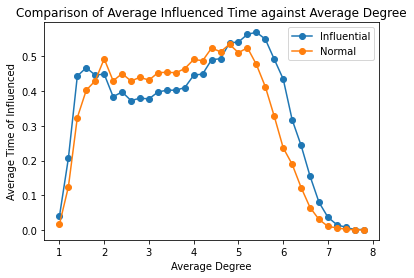

In [12]:
plt.plot(n_avg, T_influential, "-o")
plt.plot(n_avg, T_normal, "-o")
plt.ylabel("Average Time of Influenced")
plt.xlabel("Average Degree")
plt.title("Comparison of Average Influenced Time against Average Degree")
plt.legend(names)

### Storing Simulation Results

Raw simulation results are stored as npy files.

In [14]:
file_dir = "./Results"
file_name = "RG_N{}q{}phi{}avg{}sim{}.npy".format(N,int(q*100),int(phi*100),max_n_avg,num_simulations)
file_path = os.path.join(file_dir, file_name)

if not os.path.exists(file_dir):
    os.makedirs(file_dir)
np.save(file_path, tmp)

In [ ]:
np.load(file_path)